=== Participant Demographics ===
                        Count  Percent
ASR Technology No          19     82.6
               Yes          4     17.4
STEM           Yes         18     78.3
               No           5     21.7
Expertise      Medical      4     17.4
               Legal        4     17.4
=== QB7 Responses ===
  QB7 Response  Count  Percent
0          Yes     18     78.3
1           No      5     21.7
[[ 9  5  6  3]
 [23  0  0  0]]
[[ 2  3 10  8]
 [ 0  0  0 23]]
[[ 3  4  5 11]
 [ 0  0  0 23]]
[[ 5  6  8  4]
 [19  3  1  0]]
[[ 2  7 11  3]
 [ 2  1  0 20]]
[[ 2  6 15]
 [ 0  0 23]]


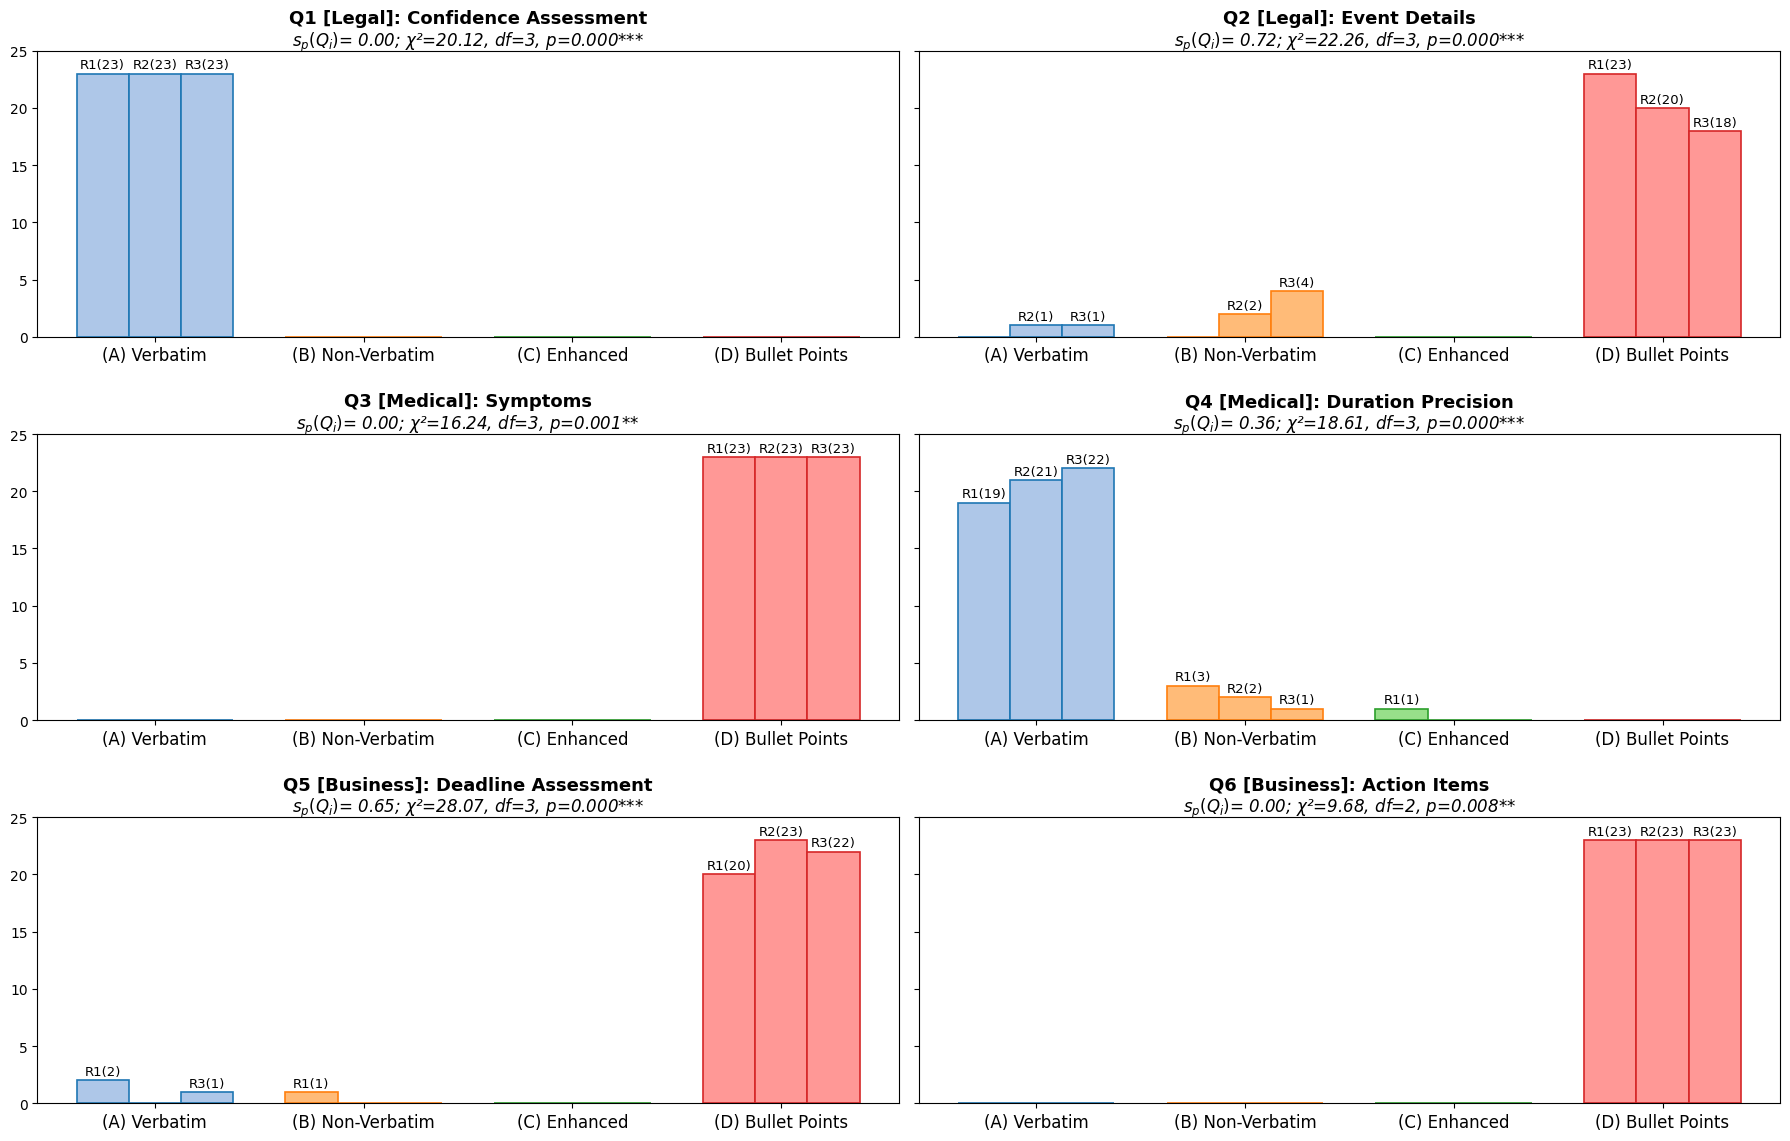

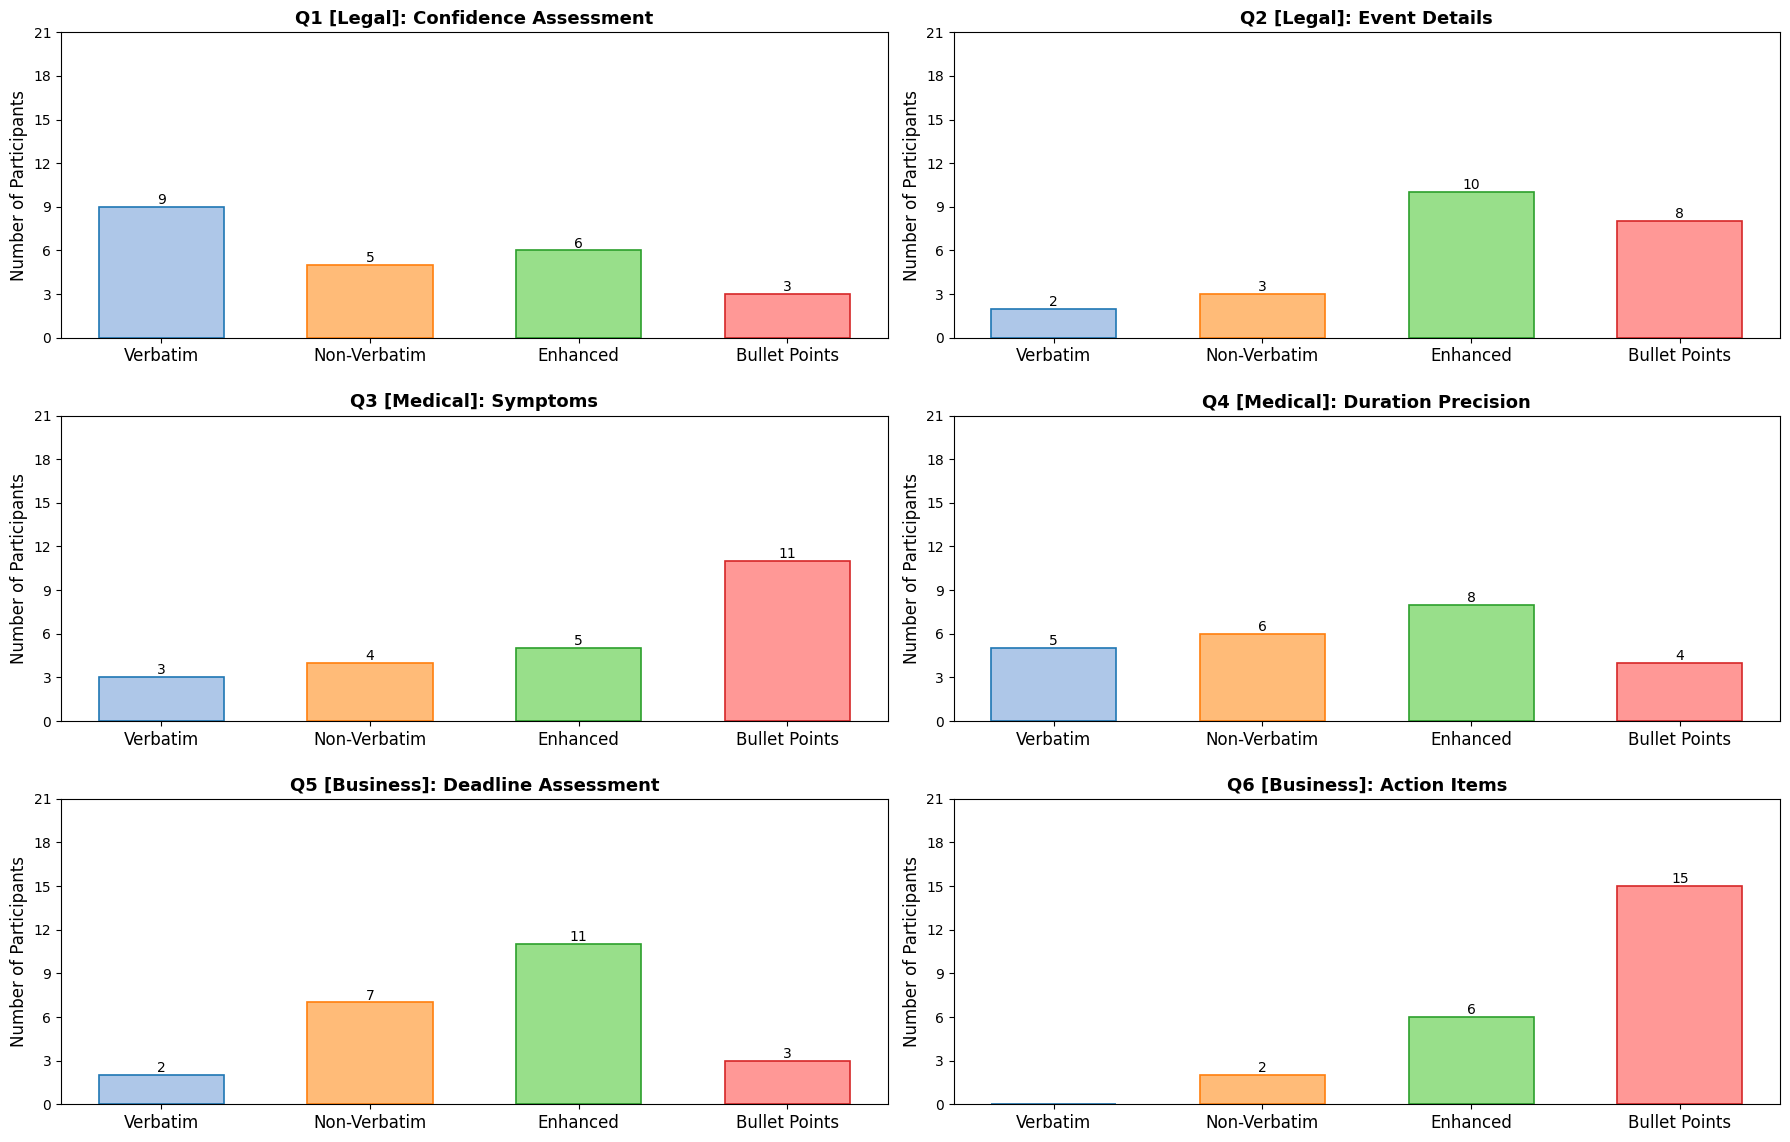

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import numpy as np
from scipy.stats import chi2_contingency

# --- SETTINGS ---
colors = {'A': '#aec7e8', 'B': '#ffbb78', 'C': '#98df8a', 'D': '#ff9896'}
borders = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728'}
user_label_map = {'A': 'Verbatim', 'B': 'Non-Verbatim', 'C': 'Enhanced', 'D': 'Bullet Points'}
llm_label_map = {'A': '(A) Verbatim', 'B': '(B) Non-Verbatim', 'C': '(C) Enhanced', 'D': '(D) Bullet Points'}
response_order = ['A', 'B', 'C', 'D']
transcript_order = list(user_label_map.values())

question_labels = {
    'Q1': 'Q1 [Legal]: Confidence Assessment',
    'Q2': 'Q2 [Legal]: Event Details',
    'Q3': 'Q3 [Medical]: Symptoms',
    'Q4': 'Q4 [Medical]: Duration Precision',
    'Q5': 'Q5 [Business]: Deadline Assessment',
    'Q6': 'Q6 [Business]: Action Items',
}

# --- LOAD DATA ---
df = pd.read_csv("results.csv")
df2 = pd.read_csv("human_results.csv").replace({k: v for k, v in user_label_map.items()})

df['response_encoded'] = df['response'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4})

# --- STATS ---
questions = sorted(df['question_name'].unique())
global_max = df.groupby(['question_name', 'round', 'response']).size().max()

def sigstars(p): return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""


# --- Participant Demographics Summary ---

# QA1: ASR Technology
asr_counts = df2['QA1'].value_counts().rename_axis('ASR').reset_index(name='Count')
asr_counts['Percent'] = (asr_counts['Count'] / len(df2) * 100).round(1)

# QA2: STEM
stem_counts = df2['QA2'].value_counts().rename_axis('STEM').reset_index(name='Count')
stem_counts['Percent'] = (stem_counts['Count'] / len(df2) * 100).round(1)

# QA3: Legal / Medical Expertise
expertise_counts = df2['QA3'].value_counts().rename_axis('Expertise').reset_index(name='Count')
expertise_counts['Percent'] = (expertise_counts['Count'] / len(df2) * 100).round(1)

# Combine into one summary table
summary_table = pd.concat({
    "ASR Technology": asr_counts.set_index('ASR'),
    "STEM": stem_counts.set_index('STEM'),
    "Expertise": expertise_counts.set_index('Expertise')
}, axis=0)

print("=== Participant Demographics ===")
print(summary_table)


# --- Preference Question Summary ---
qb7_counts = df2["QB7"].value_counts().rename_axis("QB7 Response").reset_index(name='Count')
qb7_counts["Percent"] = (qb7_counts["Count"] / len(df2) * 100).round(1)

print("=== QB7 Responses ===")
print(qb7_counts)

# --- PLOT 1: LLM Results + Chi Squared ---
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for i, q in enumerate(questions):
    ax = axes[i]
    ax.set_ylim(0, global_max+2)
    counts = df[df['question_name'] == q].groupby(['round', 'response']).size().unstack(fill_value=0).T.reindex(response_order, fill_value=0)
    x = np.arange(len(response_order))
    bar_width = 0.25

    # Plot the bars by round
    for j, col in enumerate(counts.columns):
        bars = ax.bar(
            x + j * bar_width,
            counts[col],
            width=bar_width,
            color=[colors[r] for r in response_order],
            edgecolor=[borders[r] for r in response_order],
            linewidth=1.2,
            label=f"Round {col}"
        )

        # Add round labels above each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.2,
                    f"R{col}({height})",
                    ha='center',
                    va='bottom',
                    fontsize=9.5,
                    # fontweight='bold'
                )

    # Set x-axis tick positions and labels
    ax.set_xticks(x + bar_width)  # centers labels between bars
    ax.set_xticklabels(
        [llm_label_map[r] for r in response_order],
        fontsize=12
    )

    # --- Pooled std deviation across rounds ---
    spooled_numer = 0
    spooled_denom = 0
    for j, col in enumerate(counts.columns):  # each round
        responses = df[(df['question_name'] == q) & (df['round'] == col)]['response_encoded']
        n_p = len(responses)
        if n_p > 1:
            s_p2 = responses.var(ddof=1)  # sample variance
            spooled_numer += (n_p - 1) * s_p2
            spooled_denom += (n_p - 1)

    s_pooled = np.sqrt(spooled_numer / spooled_denom) if spooled_denom > 0 else np.nan

    # --- Chi-squared (Round 1 vs Human) ---
    llm_counts = df[(df['question_name'] == q) & (df['round'] == 1)]['response'] \
        .value_counts().reindex(response_order, fill_value=0).values
    human_q = "QB" + q[1:]
    human_counts = df2[human_q].value_counts().reindex(transcript_order, fill_value=0).values

    # Create contingency table
    contingency = np.array([human_counts, llm_counts])

    # Remove columns where both counts are 0
    nonzero_cols = contingency.sum(axis=0) > 0
    contingency = contingency[:, nonzero_cols]
    print(contingency)

    # Chi-squared test
    if contingency.shape[1] > 1:
        chi2, p, dof = chi2_contingency(contingency)[:3]
    else:
        chi2, p, dof = 0, 1.0, 0


    # Set title with statistical results
    # Bold first line (title)
    ax.set_title(
        f"{question_labels[q]}",
        fontsize=13,
        fontweight="bold",
        pad=20
    )

    # Italic stats line (normal weight)
    ax.text(
        0.5, 0.99,
        f"$s_p(Q_i)$= {s_pooled:.2f}; χ²={chi2:.2f}, df={int(dof)}, p={p:.3f}{sigstars(p)}",
        fontsize=12,
        ha='center',
        va='bottom',
        transform=ax.transAxes,
        fontweight='normal',
        fontstyle='italic'
    )

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)
plt.savefig("llm_results.png", dpi=300)
plt.show()

# --- PLOT 2: Human Results ---
global_max2 = max(
    df2[col].value_counts().max()
    for col in df2.columns
)

fig2, axes2 = plt.subplots(3, 2, figsize=(18, 12))
for ax, (q, label) in zip(axes2.flatten(), question_labels.items()):
    counts = df2["QB" + q[1:]].value_counts().reindex(transcript_order, fill_value=0)
    bars = ax.bar(transcript_order, counts, color=[colors[k] for k in response_order],
                  edgecolor=[borders[k] for k in response_order], linewidth=1.2, width=0.6)
    ax.set_ylim(0, global_max2 + 2)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel("Number of Participants", fontsize=12)
    ax.set_title(label, fontsize=13, fontweight="bold")

    # Set x-axis font size
    ax.set_xticks(x)  # centers labels between bars
    ax.set_xticklabels(
        [user_label_map[r] for r in response_order],
        fontsize=12
    )

    for bar, val in zip(bars, counts):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.2, str(val), ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)
plt.savefig("human_results.png", dpi=300)
plt.show()



In [9]:
from scipy.stats import chisquare

# Chi-squared Test: Do Users Have Random Preferences?
print(f"{'Question':<8} {'Chi²':>8} {'df':>4} {'p-value':>10} {'Sig':>6}")
print("-" * 40)

user_chi2_results = []

for q in questions:
    # Human question label uses QB1, QB2, etc.
    human_q = "QB" + q[1:]

    # Observed counts from human responses
    observed = (
        df2[human_q]
        .value_counts()
        .reindex(transcript_order, fill_value=0)
        .values
    )

    # Expected counts if uniform distribution (random preference)
    total = observed.sum()
    expected = np.full(len(observed), total / len(observed), dtype=float)

    # Chi-squared goodness-of-fit test
    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    dfree = len(observed) - 1

    user_chi2_results.append((q, chi2, dfree, p, sigstars(p)))

    print(f"{q:<8} {chi2:>8.2f} {dfree:>4} {p:>10.4f} {sigstars(p):>6}")

Question     Chi²   df    p-value    Sig
----------------------------------------
Q1           3.26    3     0.3531       
Q2           7.78    3     0.0507       
Q3           6.74    3     0.0807       
Q4           1.52    3     0.6773       
Q5           8.83    3     0.0317      *
Q6          23.09    3     0.0000    ***


In [8]:
from scipy.stats import chisquare

# Chi-squared Test: Do LLMs Have Random Preferences?
print(f"{'Question':<8} {'Chi²':>8} {'df':>4} {'p-value':>10} {'Sig':>6}")
print("-" * 40)

chi2_results = []

for q in questions:
    # observed counts across ALL rounds/personas
    observed = (
        df[df['question_name'] == q]['response']
        .value_counts()
        .reindex(response_order, fill_value=0)
        .values
    )

    # expected counts if uniform
    total = observed.sum()
    expected = np.full(len(observed), total / len(observed), dtype=float)

    # chi-squared goodness-of-fit
    chi2, p = chisquare(f_obs=observed, f_exp=expected)
    dfree = len(observed) - 1

    chi2_results.append((q, chi2, dfree, p, sigstars(p)))

    print(f"{q:<8} {chi2:>8.2f} {dfree:>4} {p:>10.4f} {sigstars(p):>6}")

Question     Chi²   df    p-value    Sig
----------------------------------------
Q1         207.00    3     0.0000    ***
Q2         149.03    3     0.0000    ***
Q3         207.00    3     0.0000    ***
Q4         155.99    3     0.0000    ***
Q5         176.51    3     0.0000    ***
Q6         207.00    3     0.0000    ***
